In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingLR
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from itertools import product
from dataclasses import dataclass
from collections import namedtuple, defaultdict
from tasks.markov import *
from models.base_models import *
from models.pos_encoder import *
from tasks.test_markov import *
from config import *
from train import *
import figures.plot as plot
from util import *
import seaborn as sns
import torch.utils.benchmark as benchmark
from tqdm.notebook import tqdm, trange

from figures.head_view import *

torch.set_printoptions(precision=3, sci_mode=False)

%load_ext autoreload
%autoreload 2

In [2]:
# For comments, see TriggerMorkov.ipynb
def run_exp(SEQ_LEN, VOC_SIZE, BATCH_SIZE, total_trans, alpha, pos_enc="rotary", mlp_layer=None, epochs=10000, num_layers=2):

    flash = False
    
    if pos_enc in ["rotary", "abs"]:
        flash = True

    if mlp_layer is None:
        mlp_layer = num_layers - 1
        
    mlp = [False] * num_layers
    if mlp_layer < num_layers:
        mlp[mlp_layer] = True 
    mlp = tuple(mlp)
    print(mlp)
    
    config = Config(
            emb_dim=128,
            num_layers=num_layers,
            num_heads=tuple([1]*num_layers),
            identity_query=False,
            seq_len=SEQ_LEN,
            vocab_size=VOC_SIZE,
            batch_size=BATCH_SIZE,
            num_epochs=epochs,
            eval_iter=1000,
            pos_enc=pos_enc,
            pos_max_len=SEQ_LEN,
            get_attn=100,
            get_checkpoints=1500,
            mlp=mlp,
            activation=mlp,
            flash=flash, # Use rotary
            ff_dim=128,
            layer_norm=False,
            ngram=2,
            learning_rate=1e-4,
            task_name="latent"
        )

    sampler_config = LatentMarkovSamplerConfig(seq_len=SEQ_LEN, vocab_size=VOC_SIZE, total_trans=total_trans,
                                               batch_size=BATCH_SIZE, task_name="latent")
    
    model = Transformer(config)
    model = model.to(config.device)

    train_results = train_model_with_plot(model, config, sampler_config, show=True)

    return train_results, model

(False, True)
Max size:  32500


  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

  0%|          | 0/25000 [00:00<?, ?it/s]

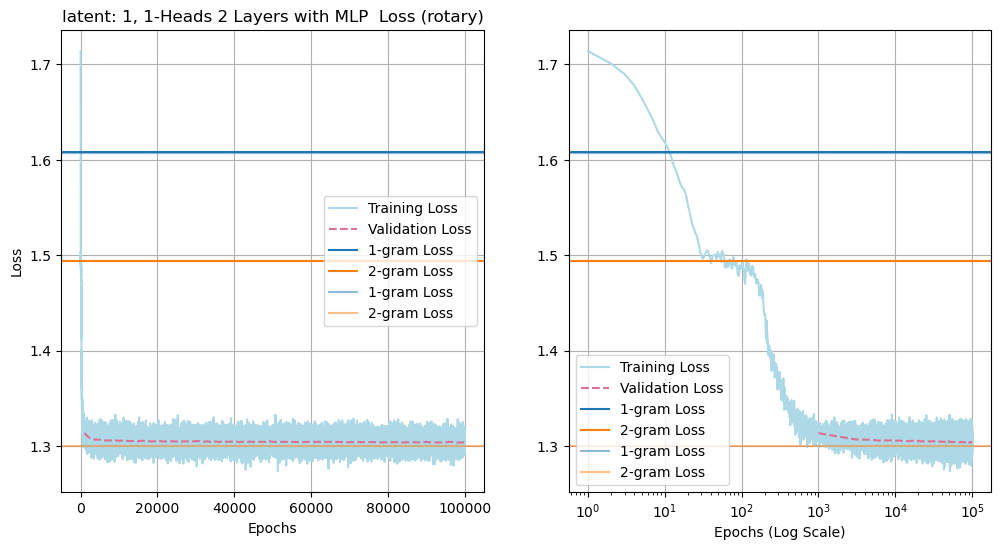

Creating images:   0%|          | 0/109 [00:00<?, ?it/s]

Creating images:   0%|          | 0/109 [00:00<?, ?it/s]

,


<IPython.core.display.Javascript object>

In [4]:
SEQ_LEN, VOC_SIZE, BATCH_SIZE = 128, 5, 32
total_trans = 2
alpha = 1
train_results, model = run_exp(SEQ_LEN, VOC_SIZE, BATCH_SIZE, total_trans, alpha, pos_enc="rotary", mlp_layer=None, epochs=100000, num_layers=2)

In [230]:
OV_2 = model.layers[1].MHA.value.weight.T @ model.layers[1].MHA.out.weight.T
range_toks = torch.arange(VOC_SIZE)
toks = model.embed(range_toks)
toks @ OV_2 @ model.output_layer.weight.T

tensor([[    -0.143,      0.211,     -1.574,      1.501,     -0.153,      0.371,
             -1.002,      0.245,     -2.099,      0.211],
        [    -0.483,     -0.131,     -0.712,      0.938,     -0.559,      0.263,
             -0.664,      0.135,     -1.029,      0.262],
        [     0.320,      0.328,     -0.718,     -0.371,      0.575,     -0.193,
              0.590,      0.120,      0.341,     -0.794],
        [     0.177,      0.512,     -1.156,      0.781,      0.334,      0.082,
             -0.295,     -0.029,     -1.034,     -0.393],
        [     0.501,     -2.059,      7.036,     -7.117,     -2.408,     -1.739,
              4.708,     -0.300,     10.424,      1.103],
        [     0.578,     -1.332,      5.385,     -5.406,     -1.666,     -1.336,
              3.919,     -0.344,      8.064,      0.662],
        [    -0.192,      1.318,     -4.612,      4.412,      1.263,      0.853,
             -2.934,      0.441,     -6.396,     -0.460],
        [     1.052,     -0

In [227]:
OV_1 = model.layers[0].MHA.value.weight.T @ model.layers[0].MHA.out.weight.T
torch.norm(OV_1, dim=-1)

tensor([0.344, 0.465, 0.363, 0.323, 0.351, 0.439, 0.350, 0.446, 0.350, 0.341,
        0.427, 0.315, 0.399, 0.335, 0.368, 0.393, 0.375, 0.377, 0.410, 0.417,
        0.318, 0.364, 0.336, 0.288, 0.310, 0.355, 0.431, 0.366, 0.409, 0.371,
        0.449, 0.394, 0.427, 0.389, 0.318, 0.368, 0.327, 0.378, 0.381, 0.354,
        0.346, 0.367, 0.357, 0.301, 0.395, 0.374, 0.379, 0.287, 0.460, 0.298,
        0.335, 0.382, 0.440, 0.438, 0.340, 0.355, 0.411, 0.384, 0.377, 0.325,
        0.425, 0.368, 0.381, 0.358, 0.369, 0.413, 0.383, 0.343, 0.365, 0.366,
        0.381, 0.349, 0.359, 0.298, 0.374, 0.424, 0.369, 0.365, 0.294, 0.349,
        0.322, 0.401, 0.464, 0.343, 0.363, 0.356, 0.367, 0.332, 0.388, 0.336,
        0.363, 0.345, 0.371, 0.376, 0.349, 0.377, 0.310, 0.315, 0.370, 0.410,
        0.402, 0.410, 0.473, 0.354, 0.390, 0.392, 0.369, 0.348, 0.390, 0.348,
        0.420, 0.377, 0.390, 0.326, 0.380, 0.401, 0.346, 0.347, 0.438, 0.337,
        0.334, 0.371, 0.367, 0.322, 0.401, 0.328, 0.384, 0.410],

In [6]:
sampler = train_results["sampler"]

In [6]:
batch, prob = sampler.test()

Latent variable:  0


In [57]:
batch

tensor([[3, 3, 5, 1, 5, 3, 2, 3, 3, 2, 3, 6, 8, 2, 4, 6, 3, 4, 0, 2, 7, 5, 1, 3,
         4, 0, 9, 3, 2, 4, 7, 8, 2, 5, 5, 8, 8, 8, 7, 0, 8, 0, 9, 1, 7, 8, 4, 0,
         7, 4, 4, 4, 0, 9, 7, 2, 2, 2, 7, 0, 9, 7, 8, 0, 0, 0, 1, 3, 6, 0, 3, 6,
         9, 9, 7, 8, 0, 7, 0, 6, 8, 9, 7, 4, 6, 5, 6, 9, 4, 6, 5, 1, 9, 6, 5, 9,
         2, 4, 8, 2, 7, 6, 5, 9, 7, 2, 4, 0, 1, 3, 0, 6, 0, 6, 4, 9, 7, 2, 5, 0,
         1, 2, 3, 8, 2, 0, 0, 7]])

In [216]:
tok1 = 6
tok2 = 8
# (6,8) appears much more often in 0 than 1
probe = torch.tensor([[tok1, tok2]*(SEQ_LEN//2)])
tok = 9
probe[0,60] = tok
logits = model(probe)[0][0]

In [217]:
(nn.Softmax(dim=1)(logits)[probe[0]==tok] - sampler.trans_matrix[0][tok].unsqueeze(0)).abs().sum(dim=-1).detach()

tensor([0.212])

In [218]:
(nn.Softmax(dim=1)(logits)[probe[0]==tok] - sampler.trans_matrix[1][tok].unsqueeze(0)).abs().sum(dim=-1).detach()

tensor([0.815])

In [173]:
sampler.trans_matrix[1][tok, tok2], sampler.trans_matrix[1][tok2, tok]

(tensor(0.170), tensor(0.083))

In [174]:
sampler.trans_matrix[0][tok, tok2], sampler.trans_matrix[0][tok2, tok]

(tensor(0.009), tensor(0.422))

In [7]:
ratio10 = (sampler.trans_matrix[1] / sampler.trans_matrix[0])
ratio01 = (sampler.trans_matrix[0] / sampler.trans_matrix[1])

In [18]:
ratio10[4,3], ratio01[4,3]

(tensor(0.625, device='cuda:0'), tensor(1.599, device='cuda:0'))